In [1]:
%matplotlib inline
import os
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np

from datetime import datetime;now = datetime.now;t00=now();

import torch
import torch.nn as nn
import torch.optim as optim

import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount("/content/drive")
print('done, mounted')
print(now())

Mounted at /content/drive
done, mounted
2020-09-21 19:41:27.745615


In [3]:
#data = np.random.rand(131,160,64,64)
#data = np.load('/content/drive/My Drive/BC-MRI-AE/data2.npy')
data = np.load('/content/drive/My Drive/abide_data_60.npy')
print(data.shape)

(1071, 1, 64, 64, 64)


In [4]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))

1
Tesla T4


In [ ]:
# Autoencoder class
class CAE(nn.Module):
    def __init__(self,input_shape,k=1):
        super().__init__()
        
        # Stuff
        self.input_shape = input_shape
        self.batch_size = input_shape[0]

        self.lrelu = torch.nn.LeakyReLU(negative_slope=.02)
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()
        self.tanh = torch.nn.Tanh()

        # Shapes and sizes
        R = np.ones(shape=self.input_shape)
        R = torch.tensor(R).float()

        bias_bool = False # Do you want padding or not 

        # Encoder
        self.enc_C1 = nn.Conv3d(in_channels=1,out_channels=4*k,kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C2 = nn.Conv3d(in_channels=4*k,out_channels=8*k,kernel_size=5, stride=2, padding=2, bias=bias_bool)
        self.enc_C3 = nn.Conv3d(in_channels=8*k,out_channels=16*k,kernel_size=5, stride=2, padding=2, bias=bias_bool)

        self.dec_C1 = nn.ConvTranspose3d(in_channels=16*k,out_channels=8*k,kernel_size=4, stride=2, padding=1,bias=bias_bool)
        self.dec_C2 = nn.ConvTranspose3d(in_channels=8*k,out_channels=4*k,kernel_size=4, stride=2, padding=1,bias=bias_bool)
        self.dec_C3 = nn.ConvTranspose3d(in_channels=4*k,out_channels=1,kernel_size=4, stride=2, padding=1,bias=bias_bool)

    def forward(self,hello):
      
        activation = self.lrelu( self.enc_C1(hello) )
        activation = self.lrelu( self.enc_C2(activation) )
        activation = self.lrelu( self.enc_C3(activation) )
        #activation_shape = activation.shape
        #activation = self.enc_L1(activation.view(self.batch_size,-1))
        #activation = self.sigmoid( self.dec_L1(activation) )
        #activation = self.relu( self.dec_L1(activation) )

        activation = self.relu( self.dec_C1(activation))
        activation = self.relu( self.dec_C2(activation) )
        #activation = self.sigmoid( self.dec_C3(activation) )
        activation = self.relu( self.dec_C3(activation) )

        return activation


In [ ]:
#dec_C3(dec_C2(dec_C1(enc_C3(enc_C2(enc_C1(data_batch.cpu()))))))

In [ ]:
## Convert data 
D = torch.tensor(data[:,:,:,:,:]).float()
D = (D-D.min()) / (D.max()-D.min())
data_batch = D[0:5,:,:,:,:]

## Model Definition
model = CAE(data_batch.shape,k=4) # Initiate mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #  use gpu if available
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3,)
#optimizer = optim.Adam(model.parameters(), lr=.01,weight_decay=.01)
#optimizer = optim.SGD(model.parameters(),lr=.1,weight_decay=.02,momentum=.9)
criterion = nn.MSELoss()
print(device)

## Training Parameters
num_epochs = 501
batch_size = 5
ndata = data.shape[0]
n_batches = np.floor(D.shape[0]/5)
batches = np.array([np.arange((i)*5,(i+1)*5) for i in range(int(n_batches))])
D = D.cuda()
track = list();

ofdir = os.path.join(os.path.curdir,'drive','My Drive','BC-MRI-AE','models')
print(ofdir)

session_name = 'CAE_Nolinear_FFT_'

cuda
./drive/My Drive/BC-MRI-AE/models


In [ ]:
def myLoss(outputs,data_batch):
  return torch.sum(torch.square(outputs.view(-1)-data_batch.view(-1)))

In [ ]:
input = D[15:20,:,:,:,:]
outputs = model.forward(input)

tensor_in =outputs[0,0,:,:,:]
a = tensor_in
b = torch.rfft(input=tensor_in.view(-1),signal_ndim=1,normalized=False)
c = torch.irfft(torch.rfft(tensor_in.view(-1),1),signal_ndim=1,normalized=False)

print(a.shape)
print(a.view(-1).shape)
print(b.shape)
print(c.shape)

torch.Size([64, 64, 64])
torch.Size([262144])
torch.Size([131073, 2])
torch.Size([262145])


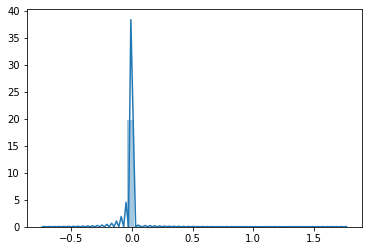

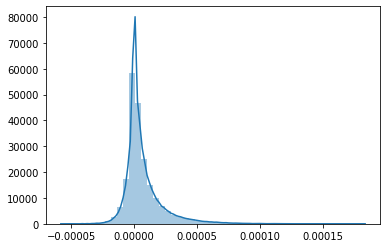

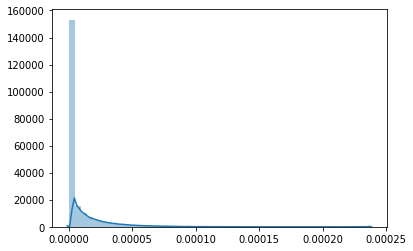

In [ ]:
plt.figure();
sns.distplot(b.cpu().detach().numpy());

plt.figure();
sns.distplot(c.cpu().detach().numpy())

plt.figure();
sns.distplot(a.view(-1).cpu().detach().numpy())

In [ ]:
t0 = datetime.now();
for epoch in range(int(num_epochs)):
    permutation = np.random.permutation(ndata)
    D = D[permutation,:,:,:,:]
    for batch_idx in range(int(n_batches)):
        optimizer.zero_grad()
        data_batch = D[batches[batch_idx,:],:,:,:,:]
        outputs = model.forward(data_batch)
        #train_loss = criterion(outputs,data_batch)
        train_loss = myLoss(outputs,data_batch)
        train_loss.backward()
        optimizer.step()
        track.append(train_loss.item())
        if batch_idx%50==0:
          print(f"epoch {epoch}/{num_epochs} | batch {batch_idx}/{n_batches} | time {str(datetime.now()-t0)} | loss {round(train_loss.item(),5)}")

    if epoch==0:
      track = track[50::] #Drop first 

    if epoch%100==0:
      ofn = os.path.join(ofdir,f'{session_name}' + f'e{epoch}_'+str(now()))
      print('saved')
      print(ofn)
      torch.save(model.state_dict(),ofn)
     
    if epoch%5==0:
      plt.figure()
      plt.subplot(1,2,1)
      plt.imshow(data_batch.cpu().detach().numpy()[0,0,32,:,:])
      plt.subplot(1,2,2)
      plt.imshow(outputs.cpu().detach().numpy()[0,0,32,:,:])
      plt.show()

      plt.figure(figsize=(10,3))
      plt.subplot(1,2,1)
      plt.plot(track)
      plt.subplot(1,2,2)
      plt.plot(track[-min(len(track),500):-1])
      plt.show()


      b = outputs.cpu().detach()
      a = data_batch.cpu().detach()
      plt.figure(figsize=(10,3))
      plt.subplot(1,2,1)
      sns.distplot(np.array(b[a>0.001]).flatten())
      plt.subplot(1,2,2)
      sns.distplot(np.array(a[a>0.001]).flatten())
      plt.show()


NameError: ignored

In [ ]:
print('all done')